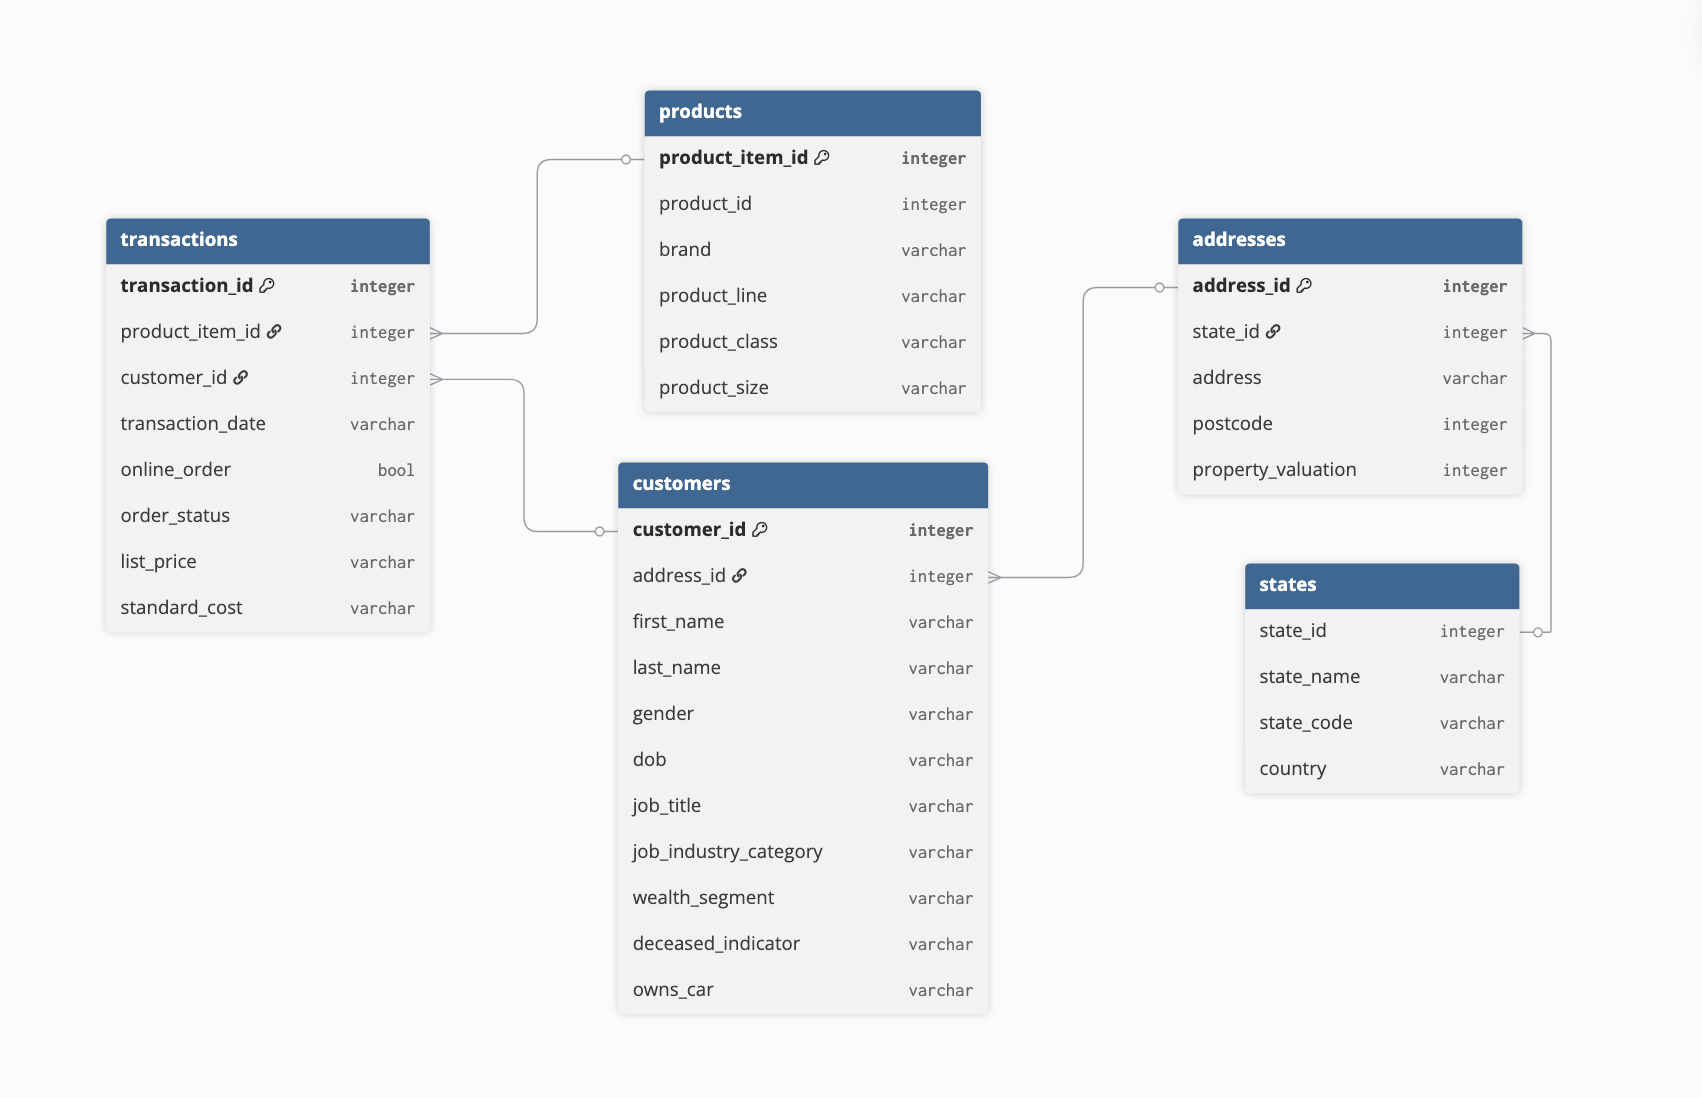

Итоговая диаграмма получившихся таблиц. Почему так получилось - см. ниже.

## Грузим данные в сыром виде в Postgres, и будем формировать финальные таблицы и связи на основе этих сырых

Получили две таблицы в 1НФ вида

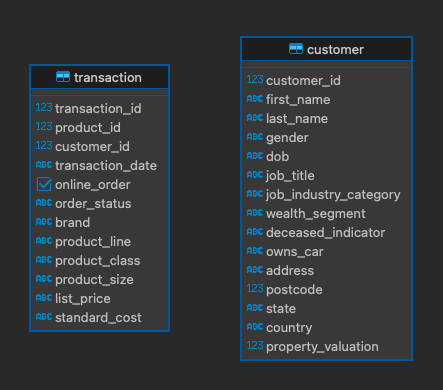


Можно утверждать, что это 1НФ, поскольку иходные данные в каждой колонке атомраные, не содержат массивов и перечислений, также есть первичные ключи (customer_id, transaction_id). Есть некоторыезначения со спорной атомарностью, например customer.address имеет вид "1605 Northfield Junction" - это улица и дом. Для целей задания можно считать, что это одно единое значение, поскольку мы не планируем рабоать с ними как с отдельными единицами.


## Приводим к 3НФ 

Для приведения к 3НФ необходимо (помимо атомарности и первичных ключей), чтобы все атрибуты в таблице зависели от primary key и только от него. На этом основании поделим исходные данные на несколько таблиц.

### Почему сейчас это не 3НФ?
В таблице customer атрибут state зависит от postcode, а не от customer_id(primary key), а country - от state.

В таблице transaction атрибуты brand, product_line, product_class_product_size по бизнес логике зависят от product_id,a не от transaction_id(primary key).


### Приведение типов данных
На схеме видно, что некоторые поля, вроде customer.dob, customer.owns_car и многих других, логически должны быть соответственно датой и булевым значением, но фактически имеют текстовый формат. Для целей задания нет смысла очищать эти данные, поэтому оставляем как есть, в текстовом виде, что и отражено на схеме. Можно было отразить на схеме логически более корректные данные, но тогда придется либо чистить/приводить данные, либо я не смогу загрузить их в таблицу.

### Какие изменения нужно сделать, чтобы привести к 3нф?
#### customer
Выносим из Customer всё, что связано с адресами. 
* address НЕ зависит от postcode (отношение много много, удивительным образом есть адреса с 2-я разными postcode), поэтому address и postcode не разделяем на разные таблицы.
* postcode зависит от штата. Штат должен зависить от страны, но страна у нас всего одна, поэтому не выделяем это в отдельную таблицу. Однако, один и тот же штат может называться по-разному (Victoria - VIC), поэтому для унификации сделаем словарь соответствий, в него же положим и страну, поскольку логически штат зависит от страны.

Итого customer разделяется на три таблицы: customers, addresses, states

#### transaction
Выносим из transaction все, что связано с продуктами
* Если проверить brand, product_line, product_class, product_size - это НЕ атрибуты product_id, потому что на один product_id может приходиться несколько brand, product_line, product_class, product_size. Не получилось даже найти комбинированный ключ. Вот хороший пример данных:

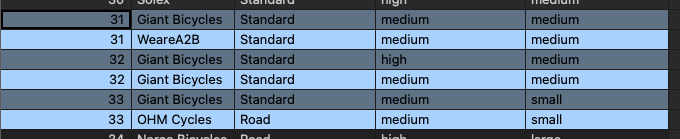

Ничто не зависит ни от чего здесь явным образом. Возможно, данные грязные - например, менялось название бренда, а айди оставался одинаковый для них. 

* Всё равно хочется отделить продукты от транзакций. Логически, с точки зрения бизнеса, это абсолютно разные сущности, и в идеале нужно
    * отразить это на схеме данных
    * в перспективе исправить данные
* Поэтому в качестве "временной" реализации в учебных целях вынесем в отдельную таблицу уникальные комбинации всех полей, связанных с продуктами: product_id, brand, product_line, product_class, product_size, и сгенерируем для них свой новый суррогатный первичный ключ.
* list_price, standard_cost оставим атрибутами транзакции -- логически, цена/стоимость может варьироваться во времени, зависеть от скидок, закупочных цен и т.п.
* На этом этапе обнаружилось, что customer_id = 5034 существует в транзакциях, но не существует в кастомерах. Для того, чтобы не ломать все зависимости, я добавила этот customer_id руками в исходные данные, см скрипты ниже

Итого transaction разделяется на две таблицы: transactions, products


## Скрипты создания таблиц и загрузки данных

In [ ]:
-- Предварительно немного чистим данные - в транзакциях есть кастомер, которого нет в таблицах с кастомерами
-- Это ломает constraints по foreign key и не дает записать данные в таблицы,
-- поэтому сначала запишем этого кастомера в исходные данные с обязательными полями
insert into hw1.customer (customer_id, first_name, gender, job_industry_category,
							wealth_segment, deceased_indicator, owns_car, address,
							postcode, state, country, property_valuation) values
('5034', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a', '0', 'n/a', 'Australia', 0)


-- создаем табллицу со штатами и странами
drop table if exists hw1.states;
create table hw1.states (
	state_id serial primary key,
	state_name text,
	state_code text,
	country text default 'Australia'
);
insert into hw1.states (state_name, state_code) values
('New South Wales', 'NSW'),
('Queensland', 'QLD'),
('Victoria', 'VIC'),
('n/a', 'n/a');


--------------------------------------------------------


-- создаем addresses
drop table if exists hw1.addresses cascade;
create table hw1.addresses(
	address_id serial primary key,
	address text not null,
	postcode int not null,
	state_id int not null,
	property_valuation int not null,
	foreign key (state_id) references hw1.states(state_id)
);
-- пишем данные
insert into hw1.addresses(address, postcode, state_id, property_valuation)
select distinct address, postcode, state_id, property_valuation
from hw1.customer
left join hw1.states on (states.state_name = customer.state or states.state_code = customer.state);


--------------------------------------------------------


-- создаем customers
drop table if exists hw1.customers cascade;
create table hw1.customers(
	customer_id int primary key,
	first_name text not null,
	last_name text,
	gender text not null,
	dob text,
	job_title text,
	job_industry_category text not null,
	wealth_segment text not null,
	deceased_indicator text not null,
	owns_car text not null,
	address_id int not null,
	foreign key (address_id) references hw1.addresses(address_id)
)

-- пишем даные
insert into hw1.customers
select 
	customer.customer_id,
	customer.first_name,
	customer.last_name, 
	customer.gender,
	customer.dob,
	customer.job_title,
	customer.job_industry_category,
	customer.wealth_segment,
	customer.deceased_indicator,
	customer.owns_car,
	addresses.address_id
from hw1.customer
left join hw1.addresses on addresses.address = customer.address and addresses.postcode = customer.postcode


------------------------------------------------------

-- создаем products
drop table if exists hw1.products cascade;
create table hw1.products(
  product_item_id serial primary key,
  product_id integer,
  brand text,
  product_line text,
  product_class text,
  product_size text	
);

-- пишем данные
insert into hw1.products (product_id, brand, product_line, product_class, product_size)
select distinct product_id, brand, product_line, product_class, product_size
from hw1."transaction";

--------------------------------------------------


-- создаем transactions
drop table if exists hw1.transactions cascade;
create table hw1.transactions(
  transaction_id integer primary key,
  product_item_id integer not null,
  customer_id integer not null,
  transaction_date text,
  online_order bool,
  order_status text not null,
  list_price text not null,
  standard_cost text,
  foreign key (product_item_id) references hw1.products(product_item_id),
  foreign key (customer_id) references hw1.customers(customer_id)
);

-- пишем данные
insert into hw1.transactions (transaction_id, product_item_id, customer_id, transaction_date, online_order, order_status, list_price, standard_cost)
select 
	transaction_id, product_item_id, customer_id, transaction_date, online_order, order_status, list_price, standard_cost
from hw1.transaction
left join hw1.products using(product_id, brand, product_line, product_class, product_size) ;


## В итоге

* Все сырые данные загрузились по созданным таблицам. 
* Полученная в базе данных схема соотвествует запланированной, которая приведена в начале ноутбука
* Атрибутный состав полученных таблиц сходится с запланированным

Здесь приведен скришот из DBeaver c фактической диаграммой базы данных, он полностью аналогичен проектному.

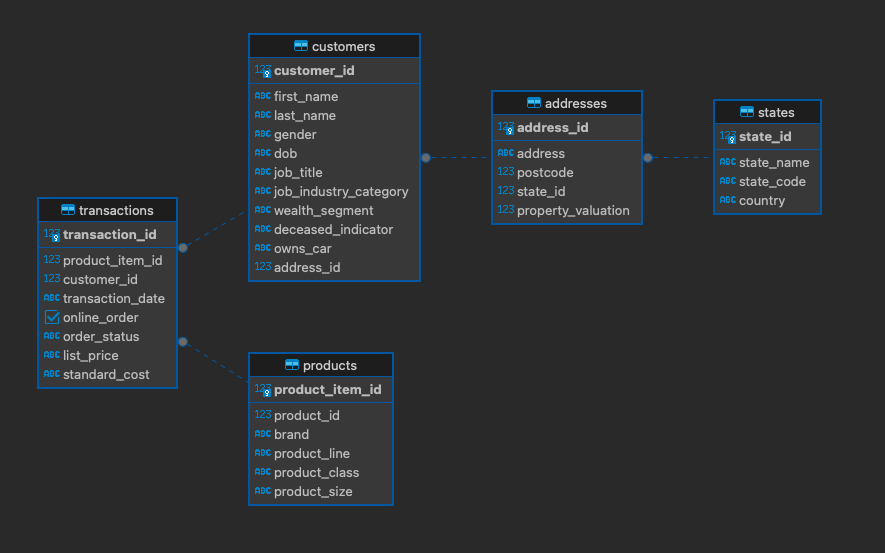